# Getting DP Article Views Data

(last updated 29 Oct)

**Tutorials**

1. https://medium.com/analytics-for-humans/submitting-your-first-google-analytics-reporting-api-request-cdda19969940
2. https://medium.com/analytics-for-humans/a-cheat-sheet-for-mastering-google-analytics-api-requests-39d36e0f3a4a
3. https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/reports/batchGet
4. https://developers.google.com/analytics/devguides/reporting/core/v4/samples

DP Website View ID: 22050415

In [225]:
# Packages neeed for authentication
import httplib2
import google.oauth2.credentials
from google_auth_httplib2 import AuthorizedHttp

#Packages needed for connecting with Google API
from googleapiclient.discovery import build as google_build

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import enum

from googleapiclient.discovery import build
from oauth2client import client
from oauth2client import file
from oauth2client import tools
import argparse
import sys
import time


In [247]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
CLIENT_SECRETS_PATH = 'client_secrets.json'

def initialize_analyticsreporting():
    """Initializes the analyticsreporting service object.
    Returns:
    analytics an authorized analyticsreporting service object.
    """
    # Parse command-line arguments.
    parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
    flags = parser.parse_args([])
    
    # Set up a Flow object to be used if we need to authenticate.
    flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

    # Prepare credentials, and authorize HTTP object with them.
    # If the credentials don't exist or are invalid run through the native client
    # flow. The Storage object will ensure that if successful the good
    # credentials will get written back to a file.
    storage = file.Storage('analyticsreporting.dat')
    credentials = storage.get()
    if credentials is None or credentials.invalid:
        credentials = tools.run_flow(flow, storage, flags)
    http = credentials.authorize(http=httplib2.Http())
  
    # Build the service object.
    analytics = build('analyticsreporting', 'v4', http=http)

    return analytics

api_client = initialize_analyticsreporting()

## Function to Get Article Views

Function tweaked from the past to call one article at a time (necessary because different articles published at different times, hence need different date ranges to get their views 1, 3, 7, 14, 30 days after date of publish)

In [248]:
# OLD
# Function to scrape page view data on DP sites - pageview data for all articles over the same time frame

def get_data(start_date, end_date = datetime.now()):

    request = {
        'viewId': '22050415',
        'dateRanges': {
            'startDate': datetime.strftime(start_date,  '%Y-%m-%d'),
            'endDate': datetime.strftime(end_date, '%Y-%m-%d')
        },
        'dimensions': [{'name': 'ga:pagePath'}],
        'metrics': [{'expression': 'ga:pageviews'},
                   {'expression': 'ga:avgTimeOnPage'}],
        'pageSize': 10000,
        'orderBys': [{
            'fieldName': 'ga:pageviews',
            'sortOrder': 'DESCENDING'
        }]
    }

    response = api_client.reports().batchGet(
        body = {
            'reportRequests': request
        }).execute()

    data = response['reports'][0]['data']['rows']
    df = pd.DataFrame(data)
    df['dimensions'] = df['dimensions'].apply(lambda x: x[0])
    df['pageviews'] = df['metrics'].apply(lambda x: int(x[0]['values'][0]))
    df['avgTimeOnPage'] = df['metrics'].apply(lambda x: x[0]['values'][1])
    df = df.drop('metrics', axis = 1)

    return df



In [249]:
# Function to scrape page view data on DP sites

def get_article_views_api(start_date, days, page_path):

    request = {
        'viewId': '22050415',
        'dateRanges': {
            'startDate': datetime.strftime(start_date,  '%Y-%m-%d'),
            'endDate': datetime.strftime(start_date + timedelta(days = days), '%Y-%m-%d')
        },
        'dimensions': [{'name': 'ga:pagePath'}],
        'metrics': [{'expression': 'ga:pageviews'},
                   {'expression': 'ga:avgTimeOnPage'}],
        'pageSize': 100000,
        'filtersExpression': 'ga:pagePath=={}'.format(page_path),
        'orderBys': [{
            'fieldName': 'ga:pageviews',
            'sortOrder': 'DESCENDING'
        }]
    }

    response = api_client.reports().batchGet(
        body = {
            'reportRequests': request
        }).execute()

    try:
        data = response['reports'][0]['data']['rows']
        df = pd.DataFrame(data)
        df['dimensions'] = df['dimensions'].apply(lambda x: x[0])
        df['pageviews'] = df['metrics'].apply(lambda x: int(x[0]['values'][0]))
        df['avgTimeOnPage'] = df['metrics'].apply(lambda x: x[0]['values'][1])
        df = df.drop('metrics', axis = 1)

        return df
    except:
        return pd.DataFrame({'dimensions': [page_path], 'pageviews': [np.nan], 'avgTimeOnPage': [np.nan]})

In [250]:
# Get the article views after certain number of days
def get_article_views(article_data, days = [1, 3, 7, 14, 30]):

    out = pd.DataFrame()
    title_url = article_data['title_url']
    page_path = '/article/' + title_url
    published_timestamp = article_data['published_date'].timestamp()
    published_date = datetime.utcfromtimestamp(published_timestamp)
    
    for day in days:
    
        out = pd.concat([out, get_article_views_api(published_date, day, page_path)], axis = 0)
        
    out.columns = ['article', 'pageviews', 'avgTimeOnPage']
    out['days'] = days
    return out

# Joining with Article Content

In [116]:
content = pd.read_csv('articles_content.csv')

In [117]:
# Convert published date to datetime
content['published_date'] = content['published_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
content = content.drop('Unnamed: 0', axis = 1)

content = content.sort_values('published_date', ascending = False)
# Filter articles written after 2010
content = content.loc[content['published_date'] > '2010-01-01', :]
content = content.reset_index(drop = True)

## Execution Code

#### Runtime

35.5 seconds for 10 articles --> 20 articles a minute


In [251]:
#article_views_data = pd.DataFrame()
# Done 4983

for i in range(5000, 15000):
    article_data = content.iloc[i, :]
    article_views_data = pd.concat([article_views_data, get_article_views(article_data, days = [3])], axis = 0)
    if i % 10 == 0:
        print(i)
        print(datetime.now())

5000
2020-11-29 20:34:04.928907
5010
2020-11-29 20:34:11.992186
5020
2020-11-29 20:34:17.905199
5030
2020-11-29 20:34:23.252568
5040
2020-11-29 20:34:28.037946
5050
2020-11-29 20:34:33.633513
5060
2020-11-29 20:34:38.312760
5070
2020-11-29 20:34:43.486511
5080
2020-11-29 20:34:48.202523
5090
2020-11-29 20:34:53.708349
5100
2020-11-29 20:34:59.969530
5110
2020-11-29 20:35:05.044515
5120
2020-11-29 20:35:10.540360
5130
2020-11-29 20:35:15.024288
5140
2020-11-29 20:35:22.044510
5150
2020-11-29 20:35:26.927920
5160
2020-11-29 20:35:34.074534
5170
2020-11-29 20:35:38.965291
5180
2020-11-29 20:35:44.391315
5190
2020-11-29 20:35:49.005791
5200
2020-11-29 20:35:56.944531
5210
2020-11-29 20:36:01.837717
5220
2020-11-29 20:36:09.184629
5230
2020-11-29 20:36:13.831289
5240
2020-11-29 20:36:19.230093
5250
2020-11-29 20:36:24.127857
5260
2020-11-29 20:36:28.711503
5270
2020-11-29 20:36:33.732971
5280
2020-11-29 20:36:38.435228
5290
2020-11-29 20:36:42.990719
5300
2020-11-29 20:36:47.568769
5310
202

7570
2020-11-29 20:54:56.607877
7580
2020-11-29 20:55:01.189174
7590
2020-11-29 20:55:05.897527
7600
2020-11-29 20:55:10.424458
7610
2020-11-29 20:55:15.310695
7620
2020-11-29 20:55:20.828376
7630
2020-11-29 20:55:25.468737
7640
2020-11-29 20:55:29.997305
7650
2020-11-29 20:55:34.438803
7660
2020-11-29 20:55:39.013045
7670
2020-11-29 20:55:43.512676
7680
2020-11-29 20:55:48.162828
7690
2020-11-29 20:55:52.717344
7700
2020-11-29 20:55:57.112103
7710
2020-11-29 20:56:01.559668
7720
2020-11-29 20:56:07.103751
7730
2020-11-29 20:56:11.479831
7740
2020-11-29 20:56:15.924372
7750
2020-11-29 20:56:20.525404
7760
2020-11-29 20:56:25.018455
7770
2020-11-29 20:56:29.550918
7780
2020-11-29 20:56:34.509866
7790
2020-11-29 20:56:39.493134
7800
2020-11-29 20:56:43.891784
7810
2020-11-29 20:56:48.433431
7820
2020-11-29 20:56:52.930661
7830
2020-11-29 20:56:57.465038
7840
2020-11-29 20:57:01.991510
7850
2020-11-29 20:57:06.532884
7860
2020-11-29 20:57:11.151928
7870
2020-11-29 20:57:15.737126
7880
202

10130
2020-11-29 21:18:55.127479
10140
2020-11-29 21:19:00.248761
10150
2020-11-29 21:19:05.982685
10160
2020-11-29 21:19:11.510162
10170
2020-11-29 21:19:16.912453
10180
2020-11-29 21:19:22.671352
10190
2020-11-29 21:19:27.904097
10200
2020-11-29 21:19:33.334244
10210
2020-11-29 21:19:38.550710
10220
2020-11-29 21:19:43.876892
10230
2020-11-29 21:19:49.414793
10240
2020-11-29 21:19:54.706237
10250
2020-11-29 21:20:00.165390
10260
2020-11-29 21:20:05.582043
10270
2020-11-29 21:20:10.879671
10280
2020-11-29 21:20:16.102724
10290
2020-11-29 21:20:21.550922
10300
2020-11-29 21:20:27.094086
10310
2020-11-29 21:20:32.612454
10320
2020-11-29 21:20:38.094314
10330
2020-11-29 21:20:43.847748
10340
2020-11-29 21:20:49.515573
10350
2020-11-29 21:20:55.853129
10360
2020-11-29 21:21:01.183057
10370
2020-11-29 21:21:06.508296
10380
2020-11-29 21:21:11.732812
10390
2020-11-29 21:21:17.549485
10400
2020-11-29 21:21:23.640442
10410
2020-11-29 21:21:30.467179
10420
2020-11-29 21:21:37.210720
10430
2020

12620
2020-11-29 21:42:23.115402
12630
2020-11-29 21:42:28.461352
12640
2020-11-29 21:42:33.981979
12650
2020-11-29 21:42:39.090518
12660
2020-11-29 21:42:44.112941
12670
2020-11-29 21:42:49.239600
12680
2020-11-29 21:42:54.672782
12690
2020-11-29 21:43:00.188188
12700
2020-11-29 21:43:05.209122
12710
2020-11-29 21:43:11.171370
12720
2020-11-29 21:43:16.279477
12730
2020-11-29 21:43:21.592949
12740
2020-11-29 21:43:26.838276
12750
2020-11-29 21:43:33.358385
12760
2020-11-29 21:43:39.651676
12770
2020-11-29 21:43:45.274264
12780
2020-11-29 21:43:50.648172
12790
2020-11-29 21:43:55.893233
12800
2020-11-29 21:44:01.761024
12810
2020-11-29 21:44:07.181207
12820
2020-11-29 21:44:13.323457
12830
2020-11-29 21:44:18.580528
12840
2020-11-29 21:44:24.688212
12850
2020-11-29 21:44:29.906546
12860
2020-11-29 21:44:35.036224
12870
2020-11-29 21:44:40.359130
12880
2020-11-29 21:44:45.462951
12890
2020-11-29 21:44:50.778856
12900
2020-11-29 21:44:56.022903
12910
2020-11-29 21:45:01.248595
12920
2020

In [252]:
article_views_data.groupby('days')['days'].count()

days
1      1983
3     15000
7     28898
14     1983
30     1983
Name: days, dtype: int64

In [253]:
article_views_data.to_csv('article_views_data.csv')

In [232]:
article_views_data['article'].nunique()

28898

In [198]:
df = article_views_data.copy()
df = df.reset_index(drop = True)
df = df.loc[df['days'] == 7, :]


In [199]:
df = df.sort_values('pageviews', ascending = False)
df = df.dropna()
df['pageviews'] = df['pageviews'].astype(int)
df['avgTimeOnPage'] = df['avgTimeOnPage'].astype(float)

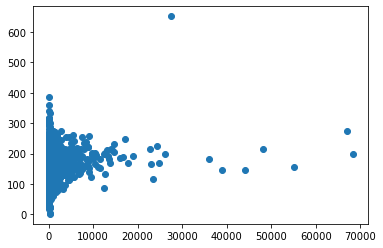

In [187]:
plt.scatter(df['pageviews'], df['avgTimeOnPage'])

In [261]:
article_views_data_7days = article_views_data.loc[article_views_data['days'] == 7, :]
article_views_data_7days = article_views_data_7days.reset_index(drop = True)
article_views_data_7days.to_csv('article_views_data.csv')